## Part 1/3: Prepare Hardware and Data

In [1]:
#import tensorflow and other libraries
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
img_folder = "map-proj-v3-classdirs"

2023-09-20 16:30:54.438858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 16:30:54.944326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Tensorflow GPU memory allocation fix
#https://github.com/tensorflow/tensorflow/issues/35264
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-09-20 16:30:55.598256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:30:55.602023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:30:55.602188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Input pipeline
Using the Keras ImageDataGenerator, the dataset is split into train and validation in an 80/20 split. Class weights are calulated after loading the dataset.

Found 9578 images belonging to 7 classes.
Found 2392 images belonging to 7 classes.

{0: 0.9773469387755102, 1: 0.3490524781341108, 2: 1.5003132832080202, 3: 7.436335403726708, 4: 0.7340588595953402, 5: 3.600751879699248, 6: 1.4905073140367258}


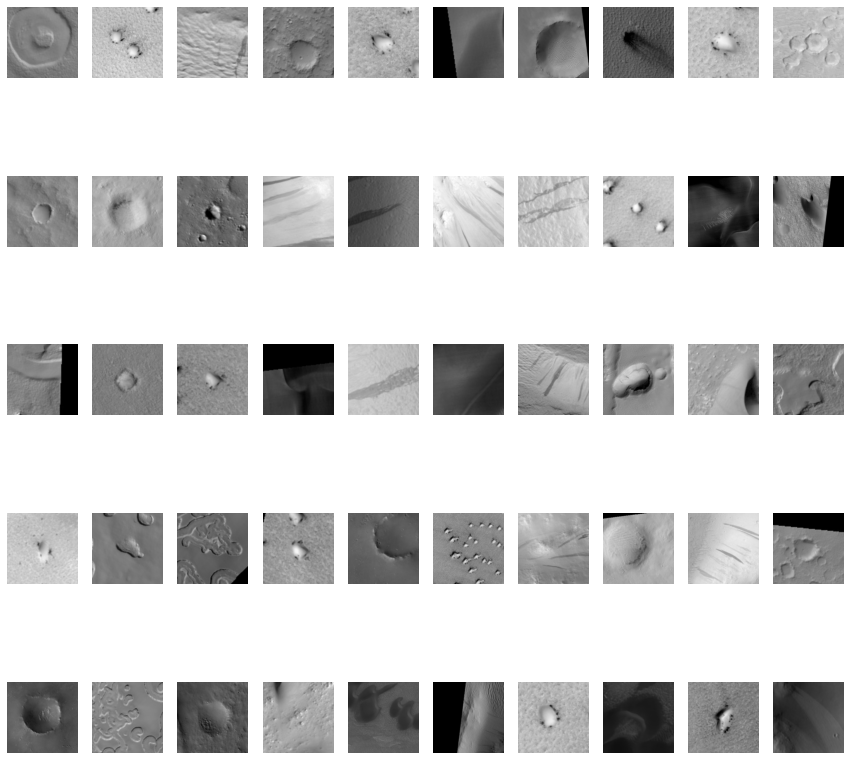

In [3]:
# https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

# Set the image size and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create ImageDataGenerator for data augmentation and loading the dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, # Normalize pixel values to [0, 1]
    validation_split=0.2 # set validation split
    # Add other data augmentation parameters as needed
)

# Load the dataset using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    img_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,       # Important: Shuffle the data to avoid issues with class weighting
    seed=123,            # Set seed for reproducibility
    subset='validation')

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)


# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))
print("")
print(class_weights_dict)

#show some images
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15,15))

for i in range(5):
    for j in range(10):

        # convert to unsigned integers for plotting
        image = next(train_generator)[0][0]

        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
        image = np.squeeze(image)

        # plot raw pixel data
        ax[i][j].imshow(image)
        ax[i][j].axis('off')

## Here, the dataset's class distribution is shown to verify the split

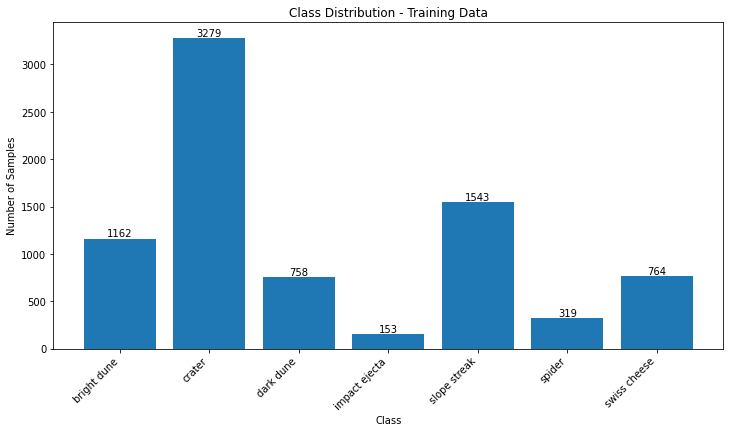

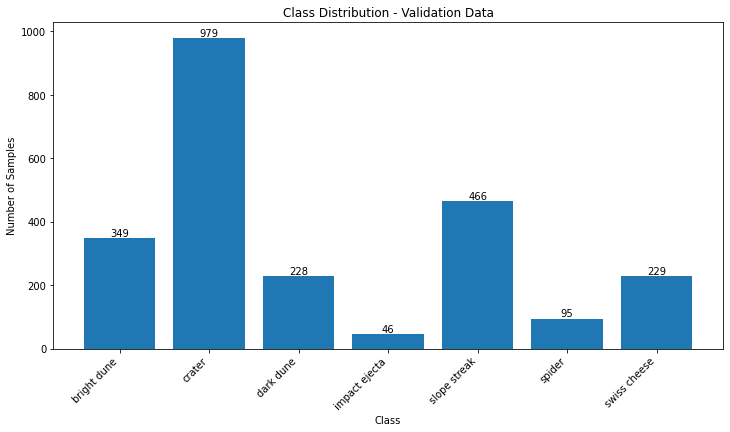

In [4]:
import matplotlib.pyplot as plt

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Count the number of samples for each class in the training data
train_class_counts = np.zeros(num_classes)
for _, labels in train_generator:
    for label in labels.argmax(axis=1):
        train_class_counts[label] += 1
    if train_generator.batch_index == 0:
        break

# Count the number of samples for each class in the validation data
validation_class_counts = np.zeros(num_classes)
for _, labels in validation_generator:
    for label in labels.argmax(axis=1):
        validation_class_counts[label] += 1
    if validation_generator.batch_index == 0:
        break

# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Plot the class distribution for training data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, train_class_counts)
plt.title("Class Distribution - Training Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(train_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

# Plot the class distribution for validation data
plt.figure(figsize=(12, 6))
plt.bar(class_labels, validation_class_counts)
plt.title("Class Distribution - Validation Data")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')

# Add number labels to each bar
for i, count in enumerate(validation_class_counts):
    plt.text(i, count, str(int(count)), ha='center', va='bottom')

plt.show()

## Part 2/3: Building and Training

In [5]:
''' old alexnet
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_height, img_width,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])'''

' old alexnet\nmodel = keras.models.Sequential([\n    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation=\'relu\', input_shape=(img_height, img_width,3)),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation=\'relu\', padding="same"),\n    keras.layers.BatchNormalization(),\n    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2

In [6]:
# new alexnet

from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

# 5 convolutional layers
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.6))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.6))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.6))

# Output Layer
model.add(Dense(7))
model.add(Activation('softmax'))

2023-09-20 16:31:02.211399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:31:02.211569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-20 16:31:02.211674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
#Precision and recall metrics
#These were removed from Keras because they may be inaccurate due to being computed batchwise
#These also don't operate per-class :(
# https://stackoverflow.com/questions/73564461/recall-and-precision-metrics-for-multi-class-classification-in-tensorflow-keras

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [8]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [9]:
#see the layers!
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 256)         0         
 g2D)                                                   

In [10]:
#set training parameters
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.0001)

In [11]:
#train the model, time to cook!


#set up tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

epochs=80

history = model.fit(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [tensorboard_callback],
    #class_weight = class_weights_dict
)

Epoch 1/80


2023-09-20 16:31:03.911034: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-09-20 16:31:04.206260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-20 16:31:04.208141: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8881b612e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-20 16:31:04.208162: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-09-20 16:31:04.211037: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-20 16:31:04.294152: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

298/299 [============================>.] - ETA: 0s - loss: 1.5429 - accuracy: 0.4121

2023-09-20 16:31:19.024067: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.
2023-09-20 16:31:20.028040: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


299/299 [==============================] - 17s 45ms/step - loss: 1.5424 - accuracy: 0.4126 - val_loss: 1.3637 - val_accuracy: 0.5739
Epoch 2/80
298/299 [============================>.] - ETA: 0s - loss: 1.1132 - accuracy: 0.6032

2023-09-20 16:31:31.462737: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.
2023-09-20 16:31:32.418396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 983040000 exceeds 10% of free system memory.


299/299 [==============================] - 12s 41ms/step - loss: 1.1127 - accuracy: 0.6036 - val_loss: 1.0880 - val_accuracy: 0.6837
Epoch 3/80
298/299 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.7181

2023-09-20 16:31:43.769380: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4026531840 exceeds 10% of free system memory.


299/299 [==============================] - 13s 42ms/step - loss: 0.7996 - accuracy: 0.7184 - val_loss: 1.0019 - val_accuracy: 0.6871
Epoch 4/80
299/299 [==============================] - 12s 41ms/step - loss: 0.6889 - accuracy: 0.7617 - val_loss: 0.9997 - val_accuracy: 0.7302
Epoch 5/80
299/299 [==============================] - 12s 41ms/step - loss: 0.5635 - accuracy: 0.8121 - val_loss: 0.8992 - val_accuracy: 0.7568
Epoch 6/80
299/299 [==============================] - 12s 42ms/step - loss: 0.4937 - accuracy: 0.8362 - val_loss: 1.0110 - val_accuracy: 0.7475
Epoch 7/80
299/299 [==============================] - 12s 41ms/step - loss: 0.4073 - accuracy: 0.8670 - val_loss: 0.9972 - val_accuracy: 0.7563
Epoch 8/80
299/299 [==============================] - 13s 42ms/step - loss: 0.3380 - accuracy: 0.8906 - val_loss: 0.8139 - val_accuracy: 0.7808
Epoch 9/80
299/299 [==============================] - 13s 43ms/step - loss: 0.2830 - accuracy: 0.9067 - val_loss: 1.1059 - val_accuracy: 0.7741
Epo

299/299 [==============================] - 15s 52ms/step - loss: 0.1618 - accuracy: 0.9533 - val_loss: 1.4104 - val_accuracy: 0.7956
Epoch 60/80
299/299 [==============================] - 15s 51ms/step - loss: 0.0341 - accuracy: 0.9897 - val_loss: 2.1459 - val_accuracy: 0.7774
Epoch 61/80
299/299 [==============================] - 15s 50ms/step - loss: 0.0239 - accuracy: 0.9924 - val_loss: 1.9474 - val_accuracy: 0.8015
Epoch 62/80
299/299 [==============================] - 15s 50ms/step - loss: 0.0530 - accuracy: 0.9856 - val_loss: 1.9689 - val_accuracy: 0.7918
Epoch 63/80
299/299 [==============================] - 15s 51ms/step - loss: 0.0198 - accuracy: 0.9950 - val_loss: 1.7851 - val_accuracy: 0.7960
Epoch 64/80
299/299 [==============================] - 15s 51ms/step - loss: 0.0136 - accuracy: 0.9963 - val_loss: 1.7694 - val_accuracy: 0.8087
Epoch 65/80
299/299 [==============================] - 15s 51ms/step - loss: 0.0279 - accuracy: 0.9906 - val_loss: 2.0760 - val_accuracy: 0.78

# 

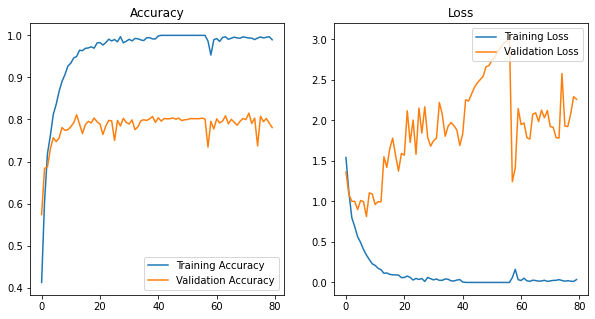

In [12]:
#visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt_size = 10

plt.figure(figsize=(plt_size, plt_size/2))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

## Part 3/3: Evaluation and Predictions

In [13]:
# evaluate the accuracy
score = model.evaluate(validation_generator, verbose=0)
print("Validation Loss: " + str(score[0]))
print("Validation Accuracy: " + str(score[1]))

print("Min Validation Loss: " + str(min(val_loss)))
print("Max Validation Accuracy: " + str(max(val_acc)))

Validation Loss: 2.2605361938476562
Validation Accuracy: 0.7805184125900269
Min Validation Loss: 0.813917338848114
Max Validation Accuracy: 0.8150337934494019


In [14]:
# generate the confusion matrix

# predict on the validation dataset
validation_predictions = model.predict(validation_generator)
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(validation_predictions, axis=1)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(validation_generator.classes, predicted_labels)

75/75 [==============================] - 2s 20ms/step


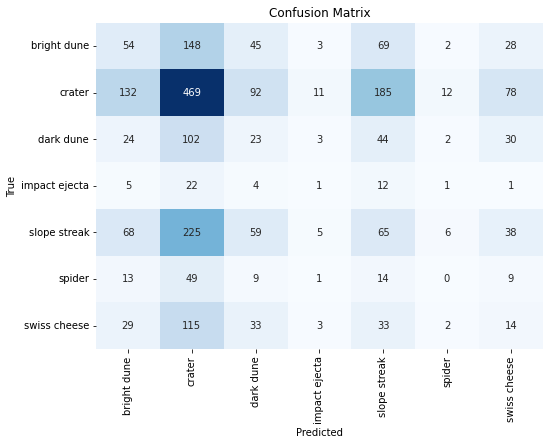

In [15]:
# visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()